In [5]:
import numpy as np
import re
import glob

In [38]:
#Takes Quantum Espresso input as input file and outputs 
#requires ibrav=0. If atomic positions are specified in crystal, use angstrom_coords
def get_coords(filepath):
    nat = 0
    current_at = 0
    current_param = 0
    
    coords = []
    cell_params = []
    
    record_coords = False
    record_params = False
    
    with open(filepath) as fp:  
        line = fp.readline()
        cnt = 1
        while line:
            if 'nat' in line.strip():
                nat = [int(x) for x in re.findall(r'\d+', line.strip())][0]
            if current_at <= nat and record_coords:
                coords.append(line.strip().split())
                current_at += 1
            elif current_at == nat and record_coords:
                record_coords = False
            
            if current_param <= 3 and record_params:
                cell_params.append(line.strip().split())
                current_param += 1
            elif current_param == 3 and record_params:
                record_params = False    
                
                
            if 'ATOMIC_POSITIONS' in line.strip():
                if 'crystal' in line.strip() or 'CRYSTAL' in line.strip():
                    atomic_pos_type = 'crystal'
                    record_coords = True
                    current_at += 1
                else:
                    atomic_pos_type = 'not_crystal'
            if 'CELL_PARAMETERS' in line.strip():
                record_params = True
                current_param += 1
                
                
            line = fp.readline()
            cnt += 1
    
    param_mags = []
    for i in cell_params:
        param_mags.append(np.linalg.norm([float(x) for x in i]))
    
    params2 = []
    for x in cell_params:
        params2.append([float(y) for y in x])
    
    angstrom_coords = []
    for atom in coords:
        name = atom[0]
        coords2 = np.array([float(x) for x in atom[1:]])
        new_coords = []

        for i,val in enumerate(coords2):
            new_coords.append([val*x for x in params2[i]])

        x,y,z = 0,0,0
        for row in new_coords:
            x += row[0]
            y += row[1]
            z += row[2]
        angstrom_coords.append([name,str(x),str(y),str(z)])
    
    types = []
    for i in coords:
        types.append(i[0])
    types = list(set(types))
    ntype = len(types)
    
    
    out_dict = {"coords": coords, "angstrom_coords":angstrom_coords,"cell_params": cell_params, "param_mags":param_mags, 
                "nat": nat, "types":types, "ntype":ntype, "atomic_pos_type":atomic_pos_type}
    
    if out_dict['atomic_pos_type'] != 'crystal':
        print("Error: Atomic position type was not crystal")
    else:
        return out_dict

def get_params_str(d,param,omit_atom=False):
    pstr = ''
    for i in d[param]:
        if omit_atom:
            for j in i[1:]:
                pstr += str(j+' ')
        else:
            for j in i:
                pstr += str(j+' ')
        pstr += '\n'
    return pstr

#gets 3D xsf data from pp.x output
def get_xsf_data(filepath,d):
    nat = d['nat']
    ntype = d['ntype']    
    
    arr = []
    dims = []
    with open(filepath) as fp:  
        line = fp.readline()
        cnt = 1
        while line:
            if cnt == 2:
                dims = [int(x) for x in line.strip().split()]
            elif cnt >=7+nat+ntype+1:
                arr.extend([float(x) for x in line.strip().split()])
            line = fp.readline()
            cnt += 1
            
    dstr = ''
    for i in dims[:3]:
        dstr += (str(i) + ' ')
    return dstr, arr


def get_xsf_string(arr,ncols=6):
    
    rem = len(arr)%ncols
    ind = 0
    l = []
    for i in range(int(len(arr)/ncols)):
        row = ''
        for j in range(ind,ind+ncols):
            row += str(arr[j]) + ' '
        l.append(row)
        ind+=ncols

    row = ''
    if rem !=0:
        for i in range(ind,ind+rem):
            row += str(arr[i]) + ' '
        l.append(row)

    final_str =''
    for i in l:
        final_str += i +'\n'
        
    return final_str

def write_xsf(outpath,dims,arr,d):
       
    xsfstr  = get_xsf_string(arr)
    file1 = open(outpath,"w") 
    L = [" CRYSTAL\n", " PRIMVEC\n", get_params_str(d,'cell_params'),
         ' PRIMCOORD\n', str(d['nat'])+'\n', get_params_str(d,'angstrom_coords'),
        ' BEGIN_BLOCK_DATAGRID_3D\n 3D_PWSCF\n DATAGRID_3D_UNKNOWN\n',
        dims +'\n', '0.000000  0.000000  0.000000\n', get_params_str(d,'cell_params'),
         xsfstr +'\n', 'END_DATAGRID_3D\n END_BLOCK_DATAGRID_3D']
    file1.writelines(L) 
    file1.close() 

def get_sum_of_list(pathlist, d):
    arrs = []
    for file in pathlist:
        dims, arr = get_xsf_data(file,d)
        arrs.append(arr)
    arr_out = np.zeros(len(arrs[0]))
    for row in arrs:
        arr_out += row
    return dims, arr_out

def single_wavefunction(xsfpath,outpath,scfpath='scf.in'):
    
    d = get_coords(scfpath)
    dims, arr = get_xsf_data(xsfpath,d)
    xsfstr  = get_xsf_string(arr)
    
    write_xsf(outpath,dims,arr,d)    


def add_wavefunctions(pathlist,outpath,scfpath='scf.in'):        
         
    d = get_coords(scfpath)
    dims, arr_out = get_sum_of_list(pathlist, d)
    write_xsf(outpath,dims,arr_out,d)


def subtract_wavefunctions(pathlist1,pathlist2,outpath,scfpath='scf.in'):        
         
    d = get_coords(scfpath)
    
    dims1, arr1 = get_sum_of_list(pathlist1, d)
    dims2, arr2 = get_sum_of_list(pathlist2, d)
    
    arr_out = np.zeros(len(arr1))
    
    for i, row in enumerate(arr1):
        arr_out[i] = arr1[i] - arr2[i]

    write_xsf(outpath,dims1,arr_out,d)
    
    return arr_out


In [50]:
homos = []
lumos = []
homo0 = []
lumo0 = []
homo3 = []
lumo3 = []
h0 = 'homo'
h3 = 'lumo'

pref = 'data/mos2/pp/'
scfpath = pref +'scf.in'
outpath = 'data/mos2/xsf/diff_of_diffs.xsf'

for filepath in glob.iglob(pref +'y.3*.txt'):
        if h0 in filepath:
            homo3.append(filepath)
        elif h3 in filepath:
            lumo3.append(filepath)

for filepath in glob.iglob(pref +'y.0*.txt'):
        if h0 in filepath:
            homo0.append(filepath)
        elif h3 in filepath:
            lumo0.append(filepath)            

arr_out0 = subtract_wavefunctions(homo0, lumo0, outpath, scfpath)
arr_out3 = subtract_wavefunctions(homo3, lumo3, outpath, scfpath)

In [57]:
arr_final = np.abs(arr_out0) - np.abs(arr_out3)
write_xsf(outpath,dims,arr_final,d)


In [48]:
dims, arr = get_xsf_data('data/mos2/pp/x.3.g.homo.txt',d)



# add_wavefunctions(homos,pref +'.homos.xsf',scfpath)
# for i in homos:
#     single_wavefunction(i,(i+'.xsf').replace('.txt',''),scfpath)

# add_wavefunctions(lumos,pref +'.lumos.xsf',scfpath)
# for i in lumos:
#     single_wavefunction(i,(i+'.xsf').replace('.txt',''),scfpath)
    
# add_wavefunctions(homolumo,pref +'.homolumo.xsf',scfpath)
# for i in homolumo:
#     single_wavefunction(i,(i+'.xsf').replace('.txt',''),scfpath)
    
    

In [54]:
np.power(arr_out0,2)

array([  4.58896256e-10,   4.75040410e-10,   5.22468131e-10, ...,
         4.67857917e-10,   4.24893126e-10,   4.02530652e-10])

In [56]:
arr_out0

array([  2.14218640e-05,   2.17954218e-05,   2.28575618e-05, ...,
         2.16300235e-05,   2.06129359e-05,   2.00631665e-05])

c:\users\kory\appdata\local\conda\conda\envs\py3\lib\site-packages\ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\kory\appdata\local\conda\conda\envs\py3\lib\site-packages\ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


(0, 0.005)

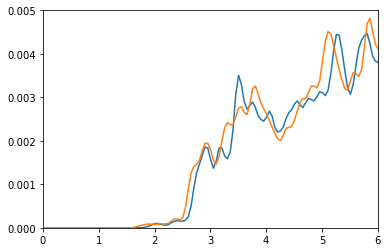

In [90]:
import pandas as pd
import matplotlib.pylab as plt
df1 = pd.read_csv('data/mos2/pp/jdos.dat', sep='       ',names=['E','JDOS'], skiprows=1)
df2 = pd.read_csv('data/mos2/pp/jdos_bn.dat', sep='    ',names=['E','JDOS'], skiprows=1)
plt.plot(df1.E,df1.JDOS)
plt.plot(df2.E,df2.JDOS)

plt.xlim([0,6])
plt.ylim([0,0.005])